In [ ]:
import numpy as np
import pandas as pd
import chess, chess.pgn
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

import pickle

from utils import fen_to_binary_features

In [2]:
def count_games_in_pgn(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    return content.count('[Event')

In [3]:
def pgn_to_dataframe(pgn_file_path):
    """
    Parse a PGN file and create a DataFrame where each row represents a position.
    Columns in the DataFrame:
        - game_id
        - move_number
        - board_fen
        - move
        - result (e.g. '1-0', '0-1', '1/2-1/2')
    """
    all_positions = []
    game_id = 0

    with open(pgn_file_path, "r", encoding="utf-8") as pgn:
        for i in tqdm(range(count_games_in_pgn(pgn_file_path))):
            game = chess.pgn.read_game(pgn)
            if game is None:
                break

            game_id += 1
            result = game.headers.get("Result", "*")
            board = game.board()

            move_number = 0
            for move in game.mainline_moves():
                board.push(move)
                move_number += 1
                position_data = {
                    "game_id": game_id,
                    "move_number": move_number,
                    "board_fen": board.fen(),
                    "move": move.uci(),
                    "result": result
                }
                all_positions.append(position_data)

    df = pd.DataFrame(all_positions)
    return df

In [4]:
# pgn_path = r"C:\Users\forbe\Downloads\lichess_elite_2024-10\lichess_elite_2024-10.pgn"
# df_positions = pgn_to_dataframe(pgn_path)
# df_positions.to_parquet(r"C:\Users\forbe\OneDrive\Personal\Documents\repos\chess_data\df_positions.parquet")

In [5]:
# df_positions = pd.read_parquet(r"C:\Users\forbe\OneDrive\Personal\Documents\repos\chess_data\df_positions.parquet")

In [6]:
RESULT_MAPPING = {"1-0": 2, "0-1": 0, "1/2-1/2": 1}

def split_dataframe(df, chunk_size):
    return [df[i:i+chunk_size] for i in range(0, len(df), chunk_size)]

def df_fen_to_binary_perspective(
    df: pd.DataFrame,
    fen_column: str = "board_fen",
    result_column: str = "result"
) -> pd.DataFrame:
    """
    Given a DataFrame that has columns:
      - fen_column (default 'board_fen'): FEN strings
      - result_column (default 'result'): game result
    Convert each FEN to a 780-dim feature vector from the side-to-move perspective.
    
    Adjust the result to reflect the perspective of the side to move.
    
    Returns a new DataFrame with:
      - 768 columns for piece placement
      - 4 columns for castling rights
      - 8 columns for en passant
      - 'result' column (adjusted to the side to move)
    """
    feature_list = []
    adjusted_results = []

    for fen, result in zip(df[fen_column], df[result_column]):
        # Extract features from the perspective of the side to move
        board = chess.Board(fen)
        side_to_move = board.turn  # True for White, False for Black
        
        if not side_to_move:  # Black to move
            # Adjust the result: swap "1-0" with "0-1"
            if result == "1-0":
                adjusted_result = "0-1"
            elif result == "0-1":
                adjusted_result = "1-0"
            else:
                adjusted_result = result  # Draw remains the same
        else:
            adjusted_result = result  # White to move, no adjustment needed

        # Convert FEN to binary features
        feature_vec = fen_to_binary_features(board.fen())
        feature_list.append(feature_vec)
        adjusted_results.append(adjusted_result)

    # Convert the list of numpy arrays to a 2D array
    feature_array = np.vstack(feature_list)

    # Create column names
    column_names = (
        [f"piece_placement_{i}" for i in range(768)]
        + [f"castling_{i}" for i in range(4)]
        + [f"en_passant_{i}" for i in range(8)]
    )

    # Build the DataFrame of features
    df_features = pd.DataFrame(feature_array, columns=column_names, index=df.index)

    # Add the adjusted result column, mapping it to numeric labels
    df_features[result_column] = adjusted_results
    df_features[result_column] = df_features[result_column].map(RESULT_MAPPING)

    return df_features


In [7]:
# df_fen_to_binary_perspective(df_positions.iloc[:100]).diff()

In [8]:
# top_positions = list(df_positions[df_positions.move_number == 4].board_fen.value_counts().index)

In [9]:
# chess.Board(top_positions[2])

In [10]:
# df_features = pd.concat([df_fen_to_binary_perspective(sub_df) for sub_df in tqdm(split_dataframe(df_positions.sample(frac=1, random_state=42).reset_index(drop=True), 100_000)[:10])])

In [11]:
# df_features.shape

In [12]:
# df_features.to_parquet(r"C:\Users\forbe\OneDrive\Personal\Documents\repos\chess_data\df_features.parquet")

In [37]:
def train_mlp_classifier(X, Y):

    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y,
        test_size=0.20,
        random_state=42,
    )

    # Optional: scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize MLP
    mlp = MLPClassifier(
        hidden_layer_sizes=(16),
        random_state=42,
        verbose=True,
        early_stopping=True
    )

    print("ready to train")

    # Fit (train) the model
    mlp.fit(X_train_scaled, y_train)

    # Evaluate
    accuracy = mlp.score(X_test_scaled, y_test)
    print(f"Test Accuracy: {accuracy:.3f}")

    y_pred = mlp.predict(X_test_scaled)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))

    # Return the trained classifier and scaler
    return mlp, scaler

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [120]:
df_features = pd.read_parquet(r"C:\Users\forbe\OneDrive\Personal\Documents\repos\chess_data\df_features.parquet")

In [123]:
df_features

,piece_placement_0,piece_placement_1,piece_placement_2,piece_placement_3,piece_placement_4,piece_placement_5,piece_placement_6,piece_placement_7,piece_placement_8,piece_placement_9,...,castling_3,en_passant_0,en_passant_1,en_passant_2,en_passant_3,en_passant_4,en_passant_5,en_passant_6,en_passant_7,result
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
999996,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,2
999997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
999998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [121]:
# pca = PCA(n_components=600)  # Number of components you want
# pca_features = pca.fit_transform(df_features[list(df_features.columns)[:-1]].values)

In [122]:
piece_categories = [
    "player_pawns",
    "player_knights",
    "player_bishops",
    "player_rooks",
    "player_queens",
    "player_kings",
    "opponent_pawns",
    "opponent_knights",
    "opponent_bishops",
    "opponent_rooks",
    "opponent_queens",
    "opponent_kings",
]

In [125]:
# for i, piece in enumerate(piece_categories):
#     df_features[piece] =  np.sum(df_features.iloc[:,list(np.arange(64)*12 + i)], axis=1)#np.sum(df_features[df_features.columns[i*64:i*64+64]], axis=1)

In [127]:
piece_feature_lookup = {}

for i, piece in enumerate(piece_categories):
    piece_feature_lookup[piece] =  df_features.iloc[:,list(np.arange(64)*12+i)].values

In [ ]:
total_pieces = np.sum(df_features[df_features.columns[:728]], axis=1)

In [ ]:
total_pieces = np.sum(df_features[df_features.columns[:728]], axis=1)

In [273]:
# X = df_features[df_features.columns[:-1]].values #
X = piece_feature_lookup["player_kings"][total_pieces < 10]
Y = df_features["result"][total_pieces < 10]

In [274]:
logistic_model = LogisticRegression().fit(X, Y)

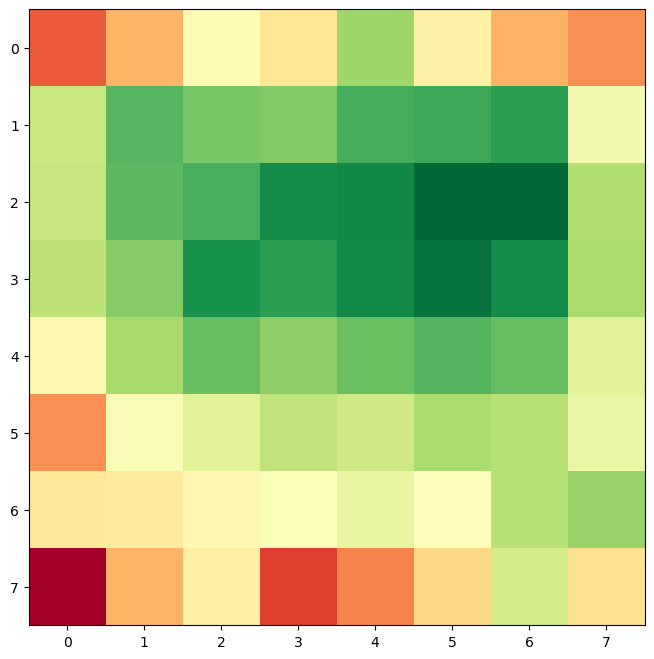

In [275]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
cmap = plt.cm.RdYlGn
plot_array = logistic_model.coef_[2].reshape(8, 8)[::-1]
norm = mcolors.Normalize(vmin=np.min(plot_array), vmax=np.max(plot_array))

plt.figure(figsize=(8, 8))
plt.imshow(plot_array, cmap=cmap, norm=norm)
plt.show()

In [140]:
logistic_scaler = StandardScaler()
logistic_model = LogisticRegression().fit(logistic_scaler.fit_transform(X), Y)

KeyboardInterrupt: 

In [81]:
logistic_model.coef_[0]

array([-0.21452491, -0.40694251, -0.46996713, -0.66726681, -1.21251512,
        0.25493275,  0.44342411,  0.4582577 ,  0.74658876,  1.30193304])

In [52]:
logistic_model.predict_proba(logistic_scaler.transform(X[5000].reshape(1, -1)))

array([[0.43541836, 0.12271666, 0.44186498]])

In [20]:
# with open("pkl/logistic_model.pkl", "wb") as f:
#     pickle.dump(logistic_model, f)

# with open("pkl/logistic_scaler.pkl", "wb") as f:
#     pickle.dump(logistic_scaler, f)

In [ ]:
# mlp_model, feature_scaler = train_mlp_classifier(X, Y)

ready to train
Iteration 1, loss = 0.98597707
Validation score: 0.500162
Iteration 2, loss = 0.95257591
Validation score: 0.511463
Iteration 3, loss = 0.94497718
Validation score: 0.512900
Iteration 4, loss = 0.94093652
Validation score: 0.515463
Iteration 5, loss = 0.93789553
Validation score: 0.516513
Iteration 6, loss = 0.93588391
Validation score: 0.518075
Iteration 7, loss = 0.93439747
Validation score: 0.517912
Iteration 8, loss = 0.93309996
Validation score: 0.516875
Iteration 9, loss = 0.93190448
Validation score: 0.518413
Iteration 10, loss = 0.93118767
Validation score: 0.521050
Iteration 11, loss = 0.93040120
Validation score: 0.520563
Iteration 12, loss = 0.92966636
Validation score: 0.520388
Iteration 13, loss = 0.92904885
Validation score: 0.520112
Iteration 14, loss = 0.92872944
Validation score: 0.521600
Iteration 15, loss = 0.92805754
Validation score: 0.520513
Iteration 16, loss = 0.92775007
Validation score: 0.522050
Iteration 17, loss = 0.92729754
Validation score: 

In [ ]:
# with open("pkl/mlp_model.pkl", "wb") as f:
#     pickle.dump(mlp_model, f)

# with open("pkl/mlp_scaler.pkl", "wb") as f:
#     pickle.dump(feature_scaler, f)